# **Importing Dataset & Libaries**

In [71]:
import sys
sys.path.insert(0,'../src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from duckdb_loader import load_mart_data, list_tables, run_query

In [72]:
query = ['SELECT * FROM ' + x  for x in list_tables()] 
tables = [run_query(query[i]) for i in range(len(list_tables()))]
mart_forecast = tables[1]
mart_forecast.info()

<class 'pandas.DataFrame'>
RangeIndex: 23077 entries, 0 to 23076
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   23077 non-null  datetime64[us]
 1   region                 23077 non-null  float64       
 2   instance_type          23077 non-null  str           
 3   year                   23077 non-null  int64         
 4   month                  23077 non-null  int64         
 5   day_of_week            23077 non-null  int64         
 6   week_of_year           23077 non-null  int64         
 7   is_weekend             23077 non-null  int32         
 8   demand                 23077 non-null  float64       
 9   daily_demand_avg       23077 non-null  float64       
 10  daily_demand_max       23077 non-null  float64       
 11  daily_demand_min       23077 non-null  float64       
 12  daily_demand_stddev    22637 non-null  float64       
 13  demand_lag_1

# **Functions**

In [73]:
# ============ MAPE Calculator ============
def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error"""
    actual = np.array(actual)
    predicted = np.array(predicted)
    mask = actual != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

In [74]:
# ============ PROPHET PATCH ============
def fixed_regressor_column_matrix(self, seasonal_features, modes):
    components = pd.DataFrame({
        'col': seasonal_features.columns,
        'component': [seasonal_features.columns[i] for i in range(len(seasonal_features.columns))]
    })
    
    if self.train_holiday_names is not None:
        holiday_components = pd.DataFrame({
            'col': self.train_holiday_names,
            'component': ['holidays'] * len(self.train_holiday_names)
        })
        components = pd.concat([components, holiday_components], ignore_index=True)
        modes[self.holidays_mode].append('holidays')
    
    components = components.reset_index(drop=True)
    component_cols = pd.crosstab(components['col'], components['component']).sort_index()
    
    for name in ['additive_terms', 'multiplicative_terms']:
        if name not in component_cols.columns:
            component_cols[name] = False
    
    return component_cols, modes

Prophet.regressor_column_matrix = fixed_regressor_column_matrix

In [89]:
# ============ Metrics Table ============
def plot_performance_table(model_name, ax, mape, mae, rmse, train_len, test_len, total_len):
    """
    Renders a styled performance metrics table on a provided Matplotlib axis.
    """
    ax.axis('tight')
    ax.axis('off')

    metrics_data = [
        ['Metric', 'Value'],
        ['MAPE (%)', f'{mape:.2f}'],
        ['MAE', f'{mae:.2f}'],
        ['RMSE', f'{rmse:.2f}'],
        ['', ''],
        ['Train Size', f'{train_len} days'],
        ['Test Size', f'{test_len} days'],
        ['Total Size', f'{total_len} days']
    ]

    table = ax.table(
        cellText=metrics_data, 
        cellLoc='left', 
        loc='center',
        colWidths=[0.4, 0.4]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2.5)

    # Style the header
    for i in range(2):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Style metrics rows (MAPE, MAE, RMSE)
    for i in range(1, 4):
        table[(i, 0)].set_facecolor('#F1F1F1')
        table[(i, 1)].set_facecolor('#FFFFFF')

    # Style info rows (Train, Test, Total sizes)
    # Note: index 4 is the empty spacer row
    for i in range(5, 8):
        table[(i, 0)].set_facecolor('#E8E8E8')
        table[(i, 1)].set_facecolor('#F8F8F8')

    ax.set_title(f"{model_name} Model Performance Metrics", fontsize=14, fontweight='bold')
    return ax

# **Prophet Modeling**

Aggregated to 1088 days from 23077 rows

Train: 870 days | Test: 218 days

Fitting Prophet model...
✓ Model fitted!



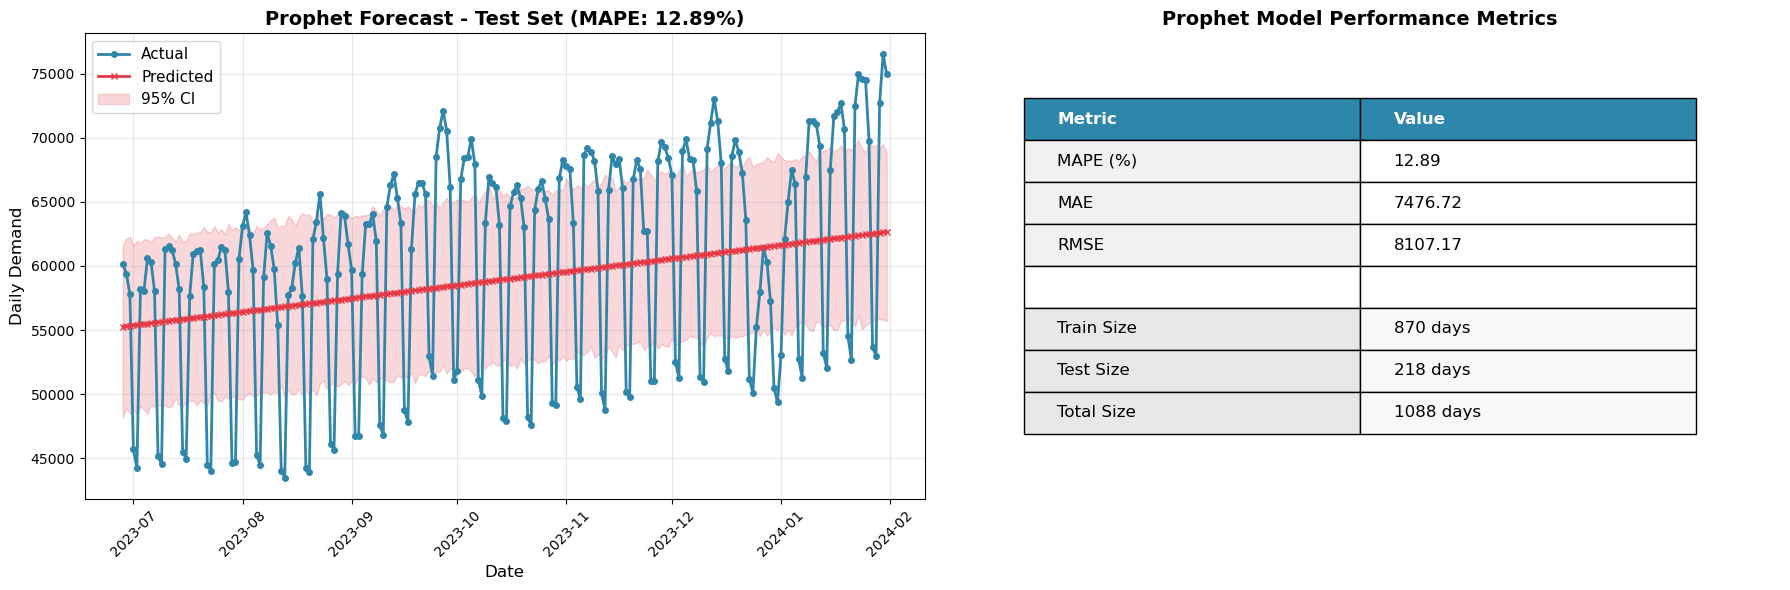

In [90]:
# ============ DATA PREP ============
df_prophet = (
    mart_forecast
    .groupby('date', as_index=False)['demand']
    .sum()
    .rename(columns={'date': 'ds', 'demand': 'y'})
)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.sort_values('ds').reset_index(drop=True)

print(f"Aggregated to {len(df_prophet)} days from {len(mart_forecast)} rows\n")

# Train/test split (80/20)
split_idx = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:split_idx]
test_prophet = df_prophet.iloc[split_idx:]

print(f"Train: {len(train_prophet)} days | Test: {len(test_prophet)} days\n")

# ============ FIT PROPHET ============
print("Fitting Prophet model...")
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5
)
model_prophet.fit(train_prophet)
print("✓ Model fitted!\n")

# ============ PREDICT ============
future_prophet = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast_prophet = model_prophet.predict(future_prophet)

# Extract test predictions
test_pred_prophet = forecast_prophet.tail(len(test_prophet)).reset_index(drop=True)
y_true_prophet = test_prophet['y'].values
y_pred_prophet = test_pred_prophet['yhat'].values

# ============ METRICS ============
mape_prophet = calculate_mape(y_true_prophet, y_pred_prophet)
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))

# ============ VISUALIZATION ============
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Forecast
ax1 = axes[0]
ax1.plot(test_prophet['ds'], y_true_prophet, label='Actual', marker='o', linewidth=2, markersize=4, color='#2E86AB')
ax1.plot(test_prophet['ds'], y_pred_prophet, label='Predicted', marker='x', linewidth=2, markersize=4, color='#E63946')
ax1.fill_between(test_prophet['ds'], test_pred_prophet['yhat_lower'], test_pred_prophet['yhat_upper'], 
                  alpha=0.2, color='#E63946', label='95% CI')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Daily Demand', fontsize=12)
ax1.set_title(f'Prophet Forecast - Test Set (MAPE: {mape_prophet:.2f}%)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Metrics Table
plot_performance_table('Prophet',axes[1], mape_prophet, mae_prophet, rmse_prophet, 
                       len(train_prophet), len(test_prophet), len(df_prophet))

plt.tight_layout()
plt.show()

# **Sarimax Modeling**

Total data points: 1088
Date range: 2021-02-08 00:00:00 to 2024-01-31 00:00:00

Train size: 870 days
Test size: 218 days



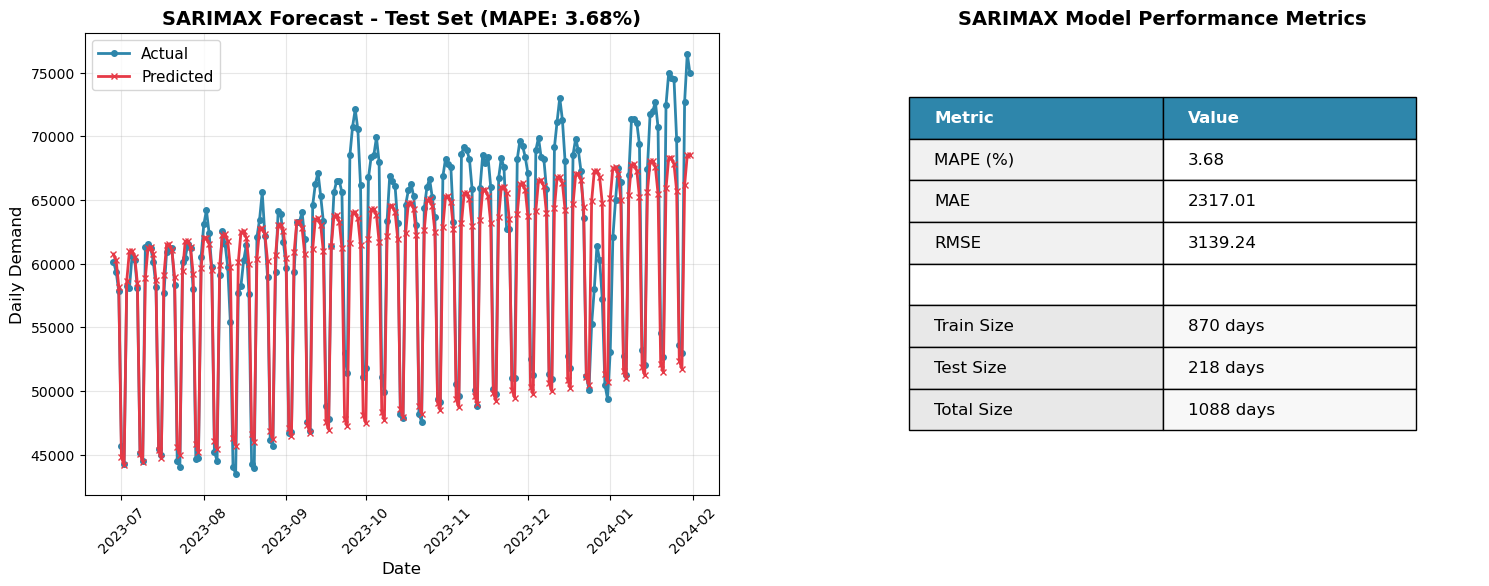

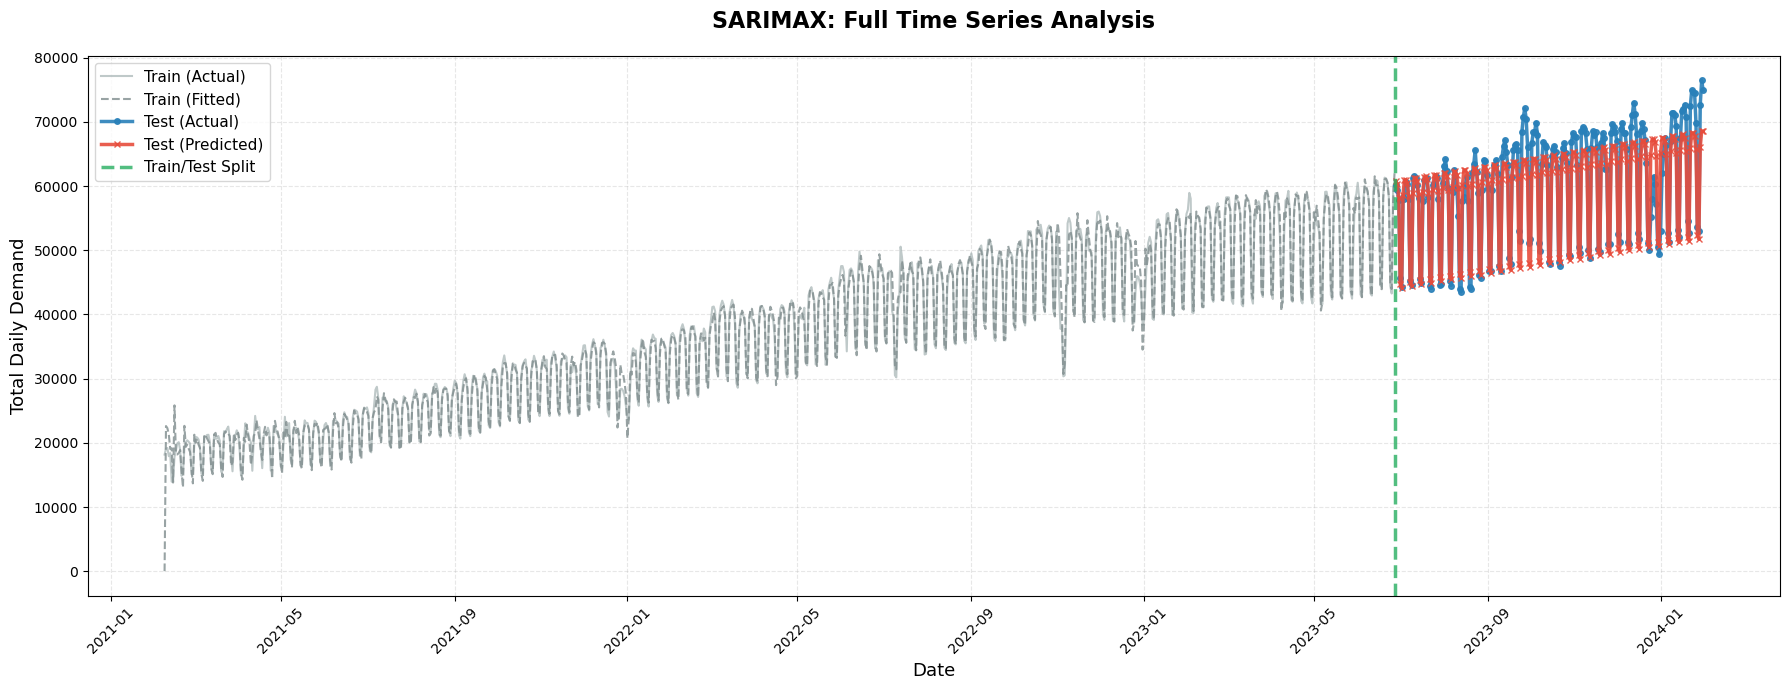


✓ SARIMAX model complete!

MODEL COMPARISON
Model           MAPE (%)     MAE          RMSE        
------------------------------------------------------------
Prophet         12.89        7476.72      8107.17     
SARIMAX         3.68         2317.01      3139.24     

✓ SARIMAX is better by 9.21 percentage points!


In [99]:
df_sarimax = df_prophet.copy()
df_sarimax.set_index('ds', inplace=True)  

print(f"Total data points: {len(df_sarimax)}")
print(f"Date range: {df_sarimax.index.min()} to {df_sarimax.index.max()}\n")

# ============ TRAIN/TEST SPLIT (80/20) ============
split_idx = int(len(df_sarimax) * 0.8)
train_sarimax = df_sarimax.iloc[:split_idx]['y']
test_sarimax = df_sarimax.iloc[split_idx:]['y']

print(f"Train size: {len(train_sarimax)} days")
print(f"Test size: {len(test_sarimax)} days\n")

# ============ FIT SARIMAX MODEL ============
model_sarimax = SARIMAX(
    train_sarimax,
    order=(1, 1, 1),              # (p,d,q) - autoregressive, differencing, moving average
    seasonal_order=(1, 1, 1, 7),  # (P,D,Q,s) - seasonal components with period=7
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarimax = model_sarimax.fit(disp=False)

# ============ FORECASTING ============
forecast_sarimax = results_sarimax.forecast(steps=len(test_sarimax))

y_true_sarimax = test_sarimax.values
y_pred_sarimax = forecast_sarimax.values

# ============ CALCULATE METRICS ============
mape_sarimax = calculate_mape(y_true_sarimax, y_pred_sarimax)
mae_sarimax = mean_absolute_error(y_true_sarimax, y_pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(y_true_sarimax, y_pred_sarimax))

# ============ VISUALIZATION 1: Test Set + Metrics ============
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Forecast
ax1 = axes[0]
ax1.plot(test_sarimax.index, y_true_sarimax, label='Actual', marker='o', linewidth=2, markersize=4, color='#2E86AB')
ax1.plot(test_sarimax.index, y_pred_sarimax, label='Predicted', marker='x', linewidth=2, markersize=4, color='#E63946')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Daily Demand', fontsize=12)
ax1.set_title(f'SARIMAX Forecast - Test Set (MAPE: {mape_sarimax:.2f}%)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Metrics Table
plot_performance_table('SARIMAX',axes[1], mape_sarimax, mae_sarimax, rmse_sarimax, 
                       len(train_sarimax), len(test_sarimax), len(df_sarimax))

# ============ Plot 3: Full Time Series with Train/Test Split ============
plt.figure(figsize=(18, 7))

in_sample_pred_sarimax = results_sarimax.fittedvalues

plt.plot(train_sarimax.index, train_sarimax.values, 
         label='Train (Actual)', color='#95A5A6', alpha=0.6, linewidth=1.5)
plt.plot(train_sarimax.index, in_sample_pred_sarimax, 
         label='Train (Fitted)', color='#7F8C8D', alpha=0.8, linewidth=1.5, linestyle='--')
plt.plot(test_sarimax.index, y_true_sarimax, 
         label='Test (Actual)', marker='o', linewidth=2.5, markersize=4, alpha=0.9, color='#2980B9')
plt.plot(test_sarimax.index, y_pred_sarimax, 
         label='Test (Predicted)', marker='x', linewidth=2.5, markersize=4, alpha=0.9, color='#E74C3C')

split_date = train_sarimax.index[-1]
plt.axvline(x=split_date, color='#27AE60', linestyle='--', linewidth=2.5, alpha=0.8, label='Train/Test Split')

plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Daily Demand', fontsize=13)
plt.title('SARIMAX: Full Time Series Analysis', fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✓ SARIMAX model complete!")

# ============ MODEL COMPARISON ============
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"{'Model':<15} {'MAPE (%)':<12} {'MAE':<12} {'RMSE':<12}")
print("-" * 60)
print(f"{'Prophet':<15} {mape_prophet:<12.2f} {mae_prophet:<12.2f} {rmse_prophet:<12.2f}")
print(f"{'SARIMAX':<15} {mape_sarimax:<12.2f} {mae_sarimax:<12.2f} {rmse_sarimax:<12.2f}")
print("=" * 60)

if mape_sarimax < mape_prophet:
    improvement = mape_prophet - mape_sarimax
    print(f"\n✓ SARIMAX is better by {improvement:.2f} percentage points!")
else:
    improvement = mape_sarimax - mape_prophet
    print(f"\n✓ Prophet is better by {improvement:.2f} percentage points!")